In [83]:
!pip install small-text
!pip install datasets
!pip install sentence-transformers
!pip install setfit
!pip install seaborn


In [99]:
import datasets
import logging
import numpy as np
import seaborn as sns
from sklearn.metrics import accuracy_score, precision_recall_fscore_support
import pandas as pd


In [85]:
dataset = datasets.load_dataset('trec')
num_classes = np.unique(dataset['train']['coarse_label']).shape[0]

In [86]:
import numpy as np
from small_text import TextDataset

In [87]:
target_labels = np.arange(num_classes)

In [88]:
train = TextDataset.from_arrays(dataset['train']['text'], np.array(dataset['train']['coarse_label']), target_labels=target_labels)
test = TextDataset.from_arrays(dataset['test']['text'], np.array(dataset['test']['coarse_label']), target_labels=target_labels)


/usr/local/lib/python3.10/dist-packages/small_text/utils/annotations.py:67: ExperimentalWarning: The function from_arrays is experimental and maybe subject to change soon.
  warnings.warn(f'The {subject} {func_or_class.__name__} is experimental '


In [89]:
from small_text.integrations.transformers.classifiers.setfit import SetFitModelArguments
from small_text.integrations.transformers.classifiers.factories import SetFitClassificationFactory


num_classes = 6

sentence_transformer_model_name = 'sentence-transformers/paraphrase-mpnet-base-v2'
setfit_model_args = SetFitModelArguments(sentence_transformer_model_name)
clf_factory = SetFitClassificationFactory(setfit_model_args, num_classes)

# Active Learning

In [90]:
from small_text import (
    PoolBasedActiveLearner,
    random_initialization_balanced,
    BreakingTies,
    SubsamplingQueryStrategy
)

In [91]:
query_strategy = SubsamplingQueryStrategy(BreakingTies())
setfit_train_kwargs = {'show_progress_bar': False}
active_learner = PoolBasedActiveLearner(clf_factory, query_strategy, train, fit_kwargs={'setfit_train_kwargs': setfit_train_kwargs})



In [92]:
# simulate a warm start
def initialize_active_learner(active_learner, y_train):

    x_indices_initial = random_initialization_balanced(y_train, n_samples=10)
    y_initial = y_train[x_indices_initial]

    active_learner.initialize_data(x_indices_initial, y_initial)

    return x_indices_initial


initial_indices = initialize_active_learner(active_learner, train.y)
labeled_indices = initial_indices

model_head.pkl not found on HuggingFace Hub, initialising classification head with random weights. You should TRAIN this model on a downstream task to use it for predictions and inference.
***** Running training *****
  Num examples = 400
  Num epochs = 1
  Total optimization steps = 13
  Total train batch size = 32


In [93]:
import gc
import torch
from sklearn.metrics import accuracy_score


num_queries = 14

y_pred = []


def evaluate(active_learner, train, test):
    y_pred = active_learner.classifier.predict(train)
    y_pred_test = active_learner.classifier.predict(test)

    test_acc = accuracy_score(y_pred_test, test.y)

    precision, recall, f1, _ = precision_recall_fscore_support(y_pred_test, test.y, average='macro',zero_division=1)

    print('Train accuracy: {:.2f}'.format(accuracy_score(y_pred, train.y)))
    print('Test accuracy: {:.2f}'.format(test_acc))

    return test_acc, y_pred_test, precision, recall


accuracy_list = []
precision_list = []
recall_list = []



for i in range(num_queries):
    q_indices = active_learner.query(num_samples=10)

    # Simulate user interaction here. Replace this for real-world usage.
    y = train.y[q_indices]

    # Return the labels for the current query to the active learner.
    active_learner.update(y)

    # memory fix: https://github.com/UKPLab/sentence-transformers/issues/1793
    gc.collect()
    torch.cuda.empty_cache()

    labeled_indices = np.concatenate([q_indices, labeled_indices])

    print('---------------')
    print('Iteration #{:d} ({} samples)'.format(i, len(labeled_indices)))
    test_acc, y_pred_test, precision, recall = evaluate(active_learner, train[labeled_indices], test)
    accuracy_list.append(test_acc)
    precision_list.append(precision)
    recall_list.append(recall)



model_head.pkl not found on HuggingFace Hub, initialising classification head with random weights. You should TRAIN this model on a downstream task to use it for predictions and inference.
***** Running training *****
  Num examples = 800
  Num epochs = 1
  Total optimization steps = 25
  Total train batch size = 32


---------------
Iteration #0 (20 samples)
Train accuracy: 1.00
Test accuracy: 0.66


model_head.pkl not found on HuggingFace Hub, initialising classification head with random weights. You should TRAIN this model on a downstream task to use it for predictions and inference.
***** Running training *****
  Num examples = 1200
  Num epochs = 1
  Total optimization steps = 38
  Total train batch size = 32


---------------
Iteration #1 (30 samples)
Train accuracy: 1.00
Test accuracy: 0.61


model_head.pkl not found on HuggingFace Hub, initialising classification head with random weights. You should TRAIN this model on a downstream task to use it for predictions and inference.
***** Running training *****
  Num examples = 1600
  Num epochs = 1
  Total optimization steps = 50
  Total train batch size = 32


---------------
Iteration #2 (40 samples)
Train accuracy: 1.00
Test accuracy: 0.74


model_head.pkl not found on HuggingFace Hub, initialising classification head with random weights. You should TRAIN this model on a downstream task to use it for predictions and inference.
***** Running training *****
  Num examples = 2000
  Num epochs = 1
  Total optimization steps = 63
  Total train batch size = 32


---------------
Iteration #3 (50 samples)
Train accuracy: 1.00
Test accuracy: 0.88


model_head.pkl not found on HuggingFace Hub, initialising classification head with random weights. You should TRAIN this model on a downstream task to use it for predictions and inference.
***** Running training *****
  Num examples = 2400
  Num epochs = 1
  Total optimization steps = 75
  Total train batch size = 32


---------------
Iteration #4 (60 samples)
Train accuracy: 1.00
Test accuracy: 0.90


model_head.pkl not found on HuggingFace Hub, initialising classification head with random weights. You should TRAIN this model on a downstream task to use it for predictions and inference.
***** Running training *****
  Num examples = 2800
  Num epochs = 1
  Total optimization steps = 88
  Total train batch size = 32


---------------
Iteration #5 (70 samples)
Train accuracy: 1.00
Test accuracy: 0.90


model_head.pkl not found on HuggingFace Hub, initialising classification head with random weights. You should TRAIN this model on a downstream task to use it for predictions and inference.
***** Running training *****
  Num examples = 3200
  Num epochs = 1
  Total optimization steps = 100
  Total train batch size = 32


---------------
Iteration #6 (80 samples)
Train accuracy: 1.00
Test accuracy: 0.90


model_head.pkl not found on HuggingFace Hub, initialising classification head with random weights. You should TRAIN this model on a downstream task to use it for predictions and inference.
***** Running training *****
  Num examples = 3600
  Num epochs = 1
  Total optimization steps = 113
  Total train batch size = 32


---------------
Iteration #7 (90 samples)
Train accuracy: 1.00
Test accuracy: 0.92


model_head.pkl not found on HuggingFace Hub, initialising classification head with random weights. You should TRAIN this model on a downstream task to use it for predictions and inference.
***** Running training *****
  Num examples = 4000
  Num epochs = 1
  Total optimization steps = 125
  Total train batch size = 32


---------------
Iteration #8 (100 samples)
Train accuracy: 1.00
Test accuracy: 0.92


model_head.pkl not found on HuggingFace Hub, initialising classification head with random weights. You should TRAIN this model on a downstream task to use it for predictions and inference.
***** Running training *****
  Num examples = 4400
  Num epochs = 1
  Total optimization steps = 138
  Total train batch size = 32


---------------
Iteration #9 (110 samples)
Train accuracy: 1.00
Test accuracy: 0.93


model_head.pkl not found on HuggingFace Hub, initialising classification head with random weights. You should TRAIN this model on a downstream task to use it for predictions and inference.
***** Running training *****
  Num examples = 4800
  Num epochs = 1
  Total optimization steps = 150
  Total train batch size = 32


---------------
Iteration #10 (120 samples)
Train accuracy: 1.00
Test accuracy: 0.94


model_head.pkl not found on HuggingFace Hub, initialising classification head with random weights. You should TRAIN this model on a downstream task to use it for predictions and inference.
***** Running training *****
  Num examples = 5200
  Num epochs = 1
  Total optimization steps = 163
  Total train batch size = 32


---------------
Iteration #11 (130 samples)
Train accuracy: 1.00
Test accuracy: 0.94


model_head.pkl not found on HuggingFace Hub, initialising classification head with random weights. You should TRAIN this model on a downstream task to use it for predictions and inference.
***** Running training *****
  Num examples = 5600
  Num epochs = 1
  Total optimization steps = 175
  Total train batch size = 32


---------------
Iteration #12 (140 samples)
Train accuracy: 1.00
Test accuracy: 0.95


model_head.pkl not found on HuggingFace Hub, initialising classification head with random weights. You should TRAIN this model on a downstream task to use it for predictions and inference.
***** Running training *****
  Num examples = 6000
  Num epochs = 1
  Total optimization steps = 188
  Total train batch size = 32


---------------
Iteration #13 (150 samples)
Train accuracy: 1.00
Test accuracy: 0.96


<module 'matplotlib.pyplot' from '/usr/local/lib/python3.10/dist-packages/matplotlib/pyplot.py'>

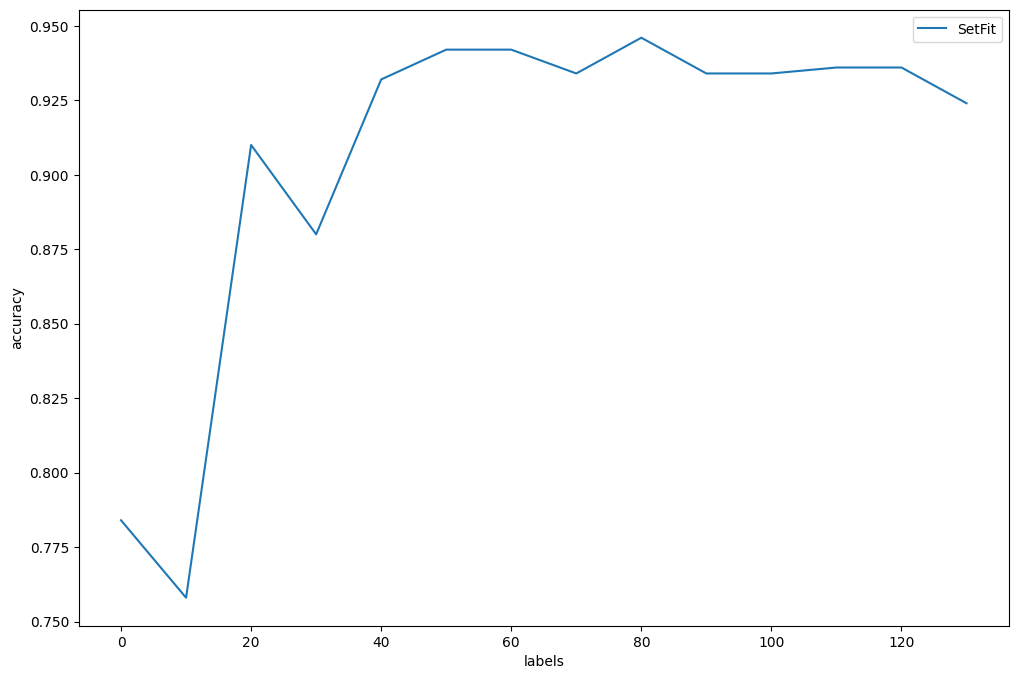

In [94]:
import matplotlib.pyplot as plt
fig = plt.figure(figsize=(12, 8))
ax = plt.axes()
ax.plot((np.arange(num_queries))*10, accuracy_list, label='SetFit')
ax.legend()
plt.ylabel('accuracy')
plt.xlabel('labels')

display(plt)

In [95]:
from sklearn.metrics import confusion_matrix


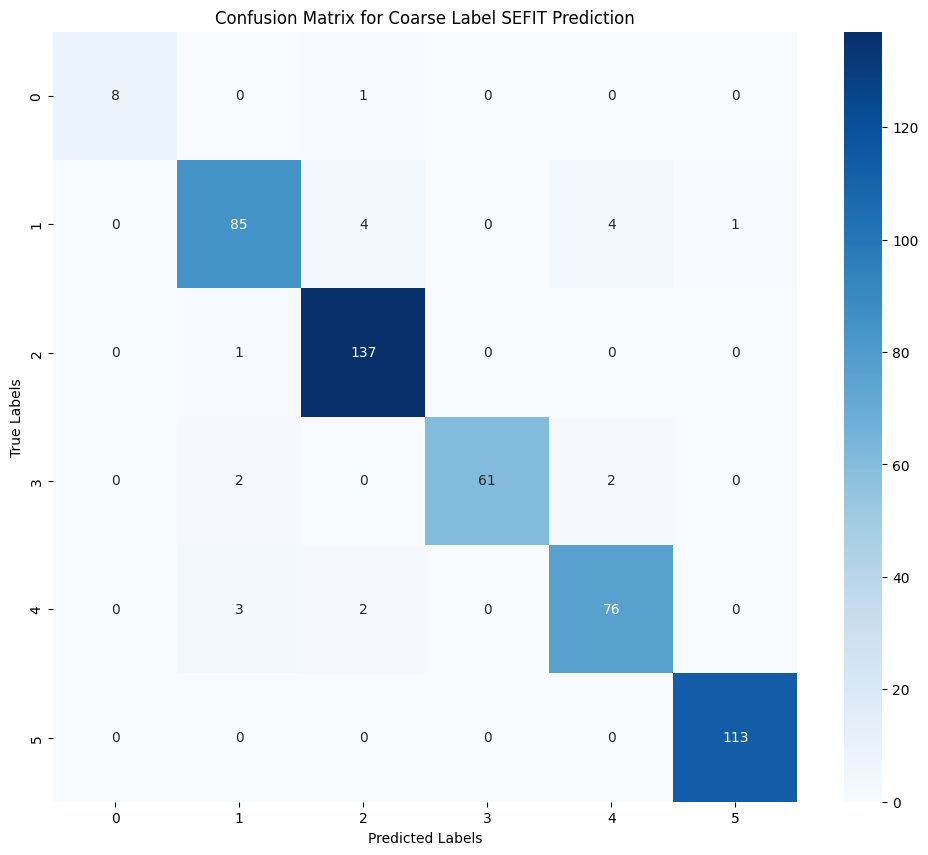

In [105]:
# Compute the confusion matrix
cm = confusion_matrix(dataset['test']['coarse_label'],y_pred_test)

# Create a heatmap of the confusion matrix
plt.figure(figsize=(12, 10))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix for Coarse Label SEFIT Prediction')
plt.show()

In [114]:
pd.DataFrame( {'actual': np.array(dataset['test']['coarse_label']),'y_pred_test' : y_pred_test} ).to_csv('Sefit_Predictions.csv',index=False)

In [100]:
setfit_label_acc_df = pd.DataFrame({'Label' :(np.arange(num_queries))*10 ,"Accuracy":accuracy_list, 'Precision' : precision_list, 'Recall': recall_list })

In [104]:
setfit_label_acc_df.to_csv('setfit_label_acc.csv', index=False)
